In [1]:
# !pip install datasets transformers accelerate torch scikit-learn matplotlib

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from datasets import load_dataset

dataset = load_dataset('./Dataset')
dataset

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 400
    })
})

In [4]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Bus', 'Car', 'Truck', 'motorcycle'], id=None)}

In [5]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('./Dataset')

# Split the training data into train and test (let's say 20% for the test set)
train_test_split = dataset['train'].train_test_split(test_size=0.1)

# Further split the training set to get a validation set (e.g., 10% of the training set)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],  # Validation set
    'test': train_test_split['test']  # Test set
}

# Display the structure of the final dataset
final_dataset


Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 324
 }),
 'val': Dataset({
     features: ['image', 'label'],
     num_rows: 36
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 40
 })}

In [6]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

In [7]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=P size=600x393>,
 'label': 2}

In [8]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Bus', 'Car', 'Truck', 'motorcycle'], id=None)}

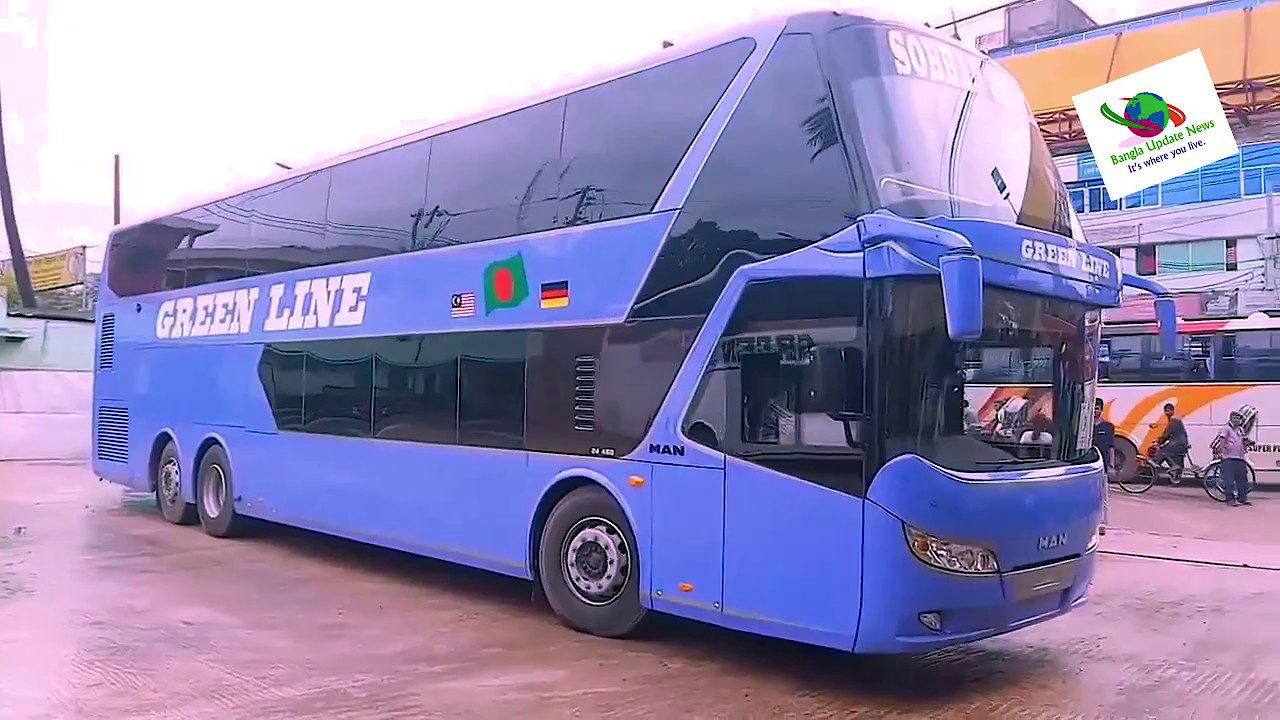

In [9]:
image = train_ds[1]['image']
image

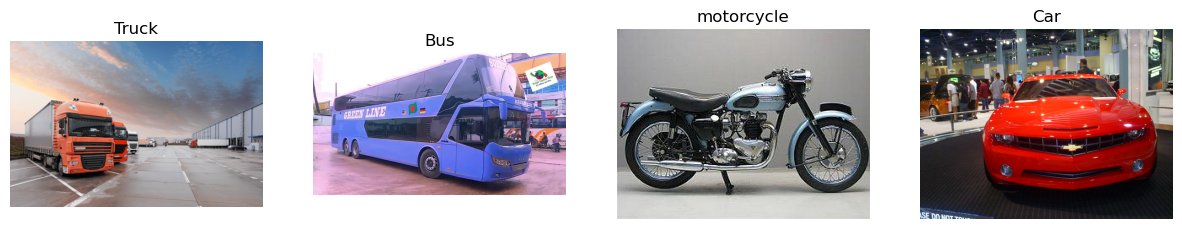

In [10]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(15, 10))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features["label"].names[sample["label"]]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features["label"].names), len(shown_labels) + 1)
        plt.imshow(sample["image"])
        plt.title(label)
        plt.axis("off")
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features["label"].names):
            break

plt.show()

In [11]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["label"]]

({0: 'Bus', 1: 'Car', 2: 'Truck', 3: 'motorcycle'}, 'Truck')

In [12]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [13]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [14]:
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

In [15]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [16]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [17]:
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [18]:
from transformers import ViTForImageClassification
labels  = dataset['train'].features['label'].names
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
  output_dir="output-models",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

c:\Users\Stephen\anaconda3\envs\UAS_CV2\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
import keras
print(keras.__version__)

2.14.0


In [21]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17732\102844377.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/42 [00:00<?, ?it/s]

c:\Users\Stephen\anaconda3\envs\UAS_CV2\lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


{'loss': 1.0858, 'grad_norm': 7.80565881729126, 'learning_rate': 0.00015714285714285716, 'epoch': 0.48}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.18166106939315796, 'eval_runtime': 5.4758, 'eval_samples_per_second': 6.574, 'eval_steps_per_second': 0.913, 'epoch': 0.48}


c:\Users\Stephen\anaconda3\envs\UAS_CV2\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'loss': 0.388, 'grad_norm': 4.646385669708252, 'learning_rate': 0.00010952380952380953, 'epoch': 0.95}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.08691808581352234, 'eval_runtime': 5.1069, 'eval_samples_per_second': 7.049, 'eval_steps_per_second': 0.979, 'epoch': 0.95}


c:\Users\Stephen\anaconda3\envs\UAS_CV2\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'loss': 0.0654, 'grad_norm': 1.015194296836853, 'learning_rate': 6.19047619047619e-05, 'epoch': 1.43}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.11231324076652527, 'eval_runtime': 5.1206, 'eval_samples_per_second': 7.03, 'eval_steps_per_second': 0.976, 'epoch': 1.43}
{'loss': 0.163, 'grad_norm': 3.0517048835754395, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.9}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.12383455783128738, 'eval_runtime': 5.0697, 'eval_samples_per_second': 7.101, 'eval_steps_per_second': 0.986, 'epoch': 1.9}
{'train_runtime': 488.6259, 'train_samples_per_second': 1.326, 'train_steps_per_second': 0.086, 'train_loss': 0.4057891972008206, 'epoch': 2.0}


TrainOutput(global_step=42, training_loss=0.4057891972008206, metrics={'train_runtime': 488.6259, 'train_samples_per_second': 1.326, 'train_steps_per_second': 0.086, 'total_flos': 1.7751054832061645e+17, 'train_loss': 0.4057891972008206, 'epoch': 2.0})

In [22]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

  0%|          | 0/5 [00:00<?, ?it/s]

{'test_loss': 0.10080830007791519, 'test_runtime': 5.9433, 'test_samples_per_second': 6.73, 'test_steps_per_second': 0.841}


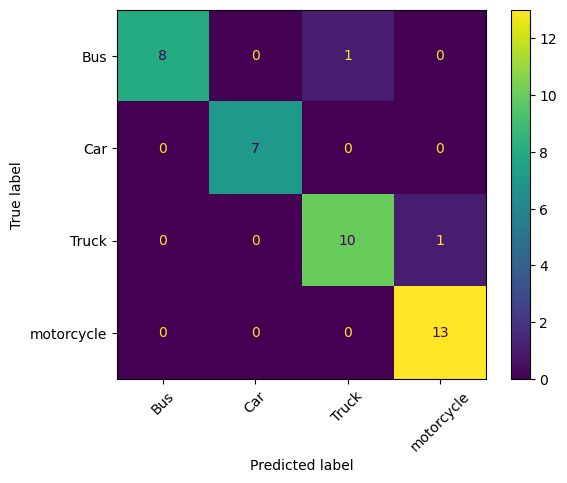

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [24]:
from sklearn.metrics import classification_report

target_names = id2label.values()

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Bus       1.00      0.89      0.94         9
         Car       1.00      1.00      1.00         7
       Truck       0.91      0.91      0.91        11
  motorcycle       0.93      1.00      0.96        13

    accuracy                           0.95        40
   macro avg       0.96      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [25]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95
